## Goals:

### Gradient Statistics:
- Layerwise/Modulewise Norm, Varaince
- Gradient Variance/Mean for same samples with different augmentation
- Gradient after each Epoch on same Task
- Gradient over the corse of training a full network
- Can we use the Data statistics of the augmented gradients to clustet examples ? 

### Observation:
- Does a high loss mean we get high mean gradient values: 
    - Exp take full dataset. 
    - Augment each sample 10 times
    - Compute statistics
    - Logg also mean and variance value
    - Compute scatter plot of this
        
- Compare the variance of data augmentation to the full dataset:
    - We assume the variance of the dataset should be largern than the variance of the sample sample
    
- Can we observe that after the first layer the network gets invariant to for example color jolor jit ? 
    

In [1]:

# gradient statistic -> over full dataset
# For each weight -> mean and std.

import os
import sys 
os.chdir(os.path.join(os.getenv('HOME'), 'ASL'))
sys.path.insert(0, os.path.join(os.getenv('HOME'), 'ASL'))
sys.path.append(os.path.join(os.path.join(os.getenv('HOME'), 'ASL') + '/src'))

from torchvision import transforms as tf
import numpy as np
import pickle
import torch
import torch.nn.functional as F
from utils_asl import file_path, load_yaml
from models_asl import FastSCNN

In [2]:
# SETUP MODEL

eval_cfg_path="cfg/eval/eval.yml"
env_cfg_path = os.path.join('cfg/env', os.environ['ENV_WORKSTATION_NAME']+ '.yml')
env_cfg = load_yaml(env_cfg_path)	
eval_cfg = load_yaml(eval_cfg_path)
device= "cuda"
model = FastSCNN(**eval_cfg['model']['cfg'])


p = os.path.join( env_cfg['base'], eval_cfg['checkpoint_load'])
print(p)
if os.path.isfile( p ):
    res = torch.load(p)
    new_statedict = {}
    for k in res['state_dict'].keys():
        if k.find('model.') != -1: 
            new_statedict[ k[6:]] = res['state_dict'][k]
    res = model.load_state_dict( new_statedict, strict=True)
    print('Restoring weights: ' + str(res))
else:
    raise Exception('Checkpoint not a file')
    
model.to(device)

/home/jonfrey/results/cluster_results/2021-03-15T10:21:22_24h_lr_001/task0-epoch=120--step=444069.ckpt
Restoring weights: <All keys matched successfully>


FastSCNN(
  (_md): ModuleDict(
    (learn_to_down): LearningToDownsample(
      (conv): _ConvBNReLU(
        (conv): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (dsconv1): _DSConv(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (dsconv2): _DSConv(
        (conv): Sequential(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), gr

In [3]:
from datasets_asl import get_dataset
import torch
from torchvision import transforms as tf

# SETUP DATALOADER
dataset_test = get_dataset(
  **eval_cfg['dataset'],
  env = env_cfg,
  output_trafo = None
  )

dataloader_test = torch.utils.data.DataLoader(dataset_test,
  shuffle = False,
  num_workers = 0,
  pin_memory = True,
  batch_size = 2, 
  drop_last = True)

globale_idx_to_image_path = dataset_test.image_pths
from visu import Visualizer
visu = Visualizer(os.getenv('HOME')+'/tmp', logger=None, epoch=0, store=False, num_classes=41)

In [4]:
import copy

def get_grad( named_params ):
    summary_grad = {}
    for i, (n,p) in enumerate( named_params ):
        mod = n.split('.')[1]
        key = mod + '_weight' if n.find('conv.') != -1 else  mod + '_bias'    
        if key not in summary_grad.keys():
            summary_grad[key] = [p.view(-1).detach()]
        else:
            summary_grad[key].append(p.view(-1).detach())
    for k in summary_grad.keys():
        summary_grad[k] = torch.cat( summary_grad[k] )

    return summary_grad

## Welfords Online Algorithm
https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm

Online mean and variance estimation:

$
\bar x_n = \frac{(n-1) \, \bar x_{n-1} + x_n}{n} = \bar x_{n-1} + \frac{x_n - \bar x_{n-1}}{n} \!
$

$
{\displaystyle s_{n}^{2}={\frac {n-2}{n-1}}\,s_{n-1}^{2}+{\frac {(x_{n}-{\bar {x}}_{n-1})^{2}}{n}}=s_{n-1}^{2}+{\frac {(x_{n}-{\bar {x}}_{n-1})^{2}}{n}}-{\frac {s_{n-1}^{2}}{n-1}},\quad n>1}
{\displaystyle \sigma _{n}^{2}={\frac {(n-1)\,\sigma _{n-1}^{2}+(x_{n}-{\bar {x}}_{n-1})(x_{n}-{\bar {x}}_{n})}{n}}=\sigma _{n-1}^{2}+{\frac {(x_{n}-{\bar {x}}_{n-1})(x_{n}-{\bar {x}}_{n})-\sigma _{n-1}^{2}}{n}}.}
$

$
{\displaystyle \sigma _{n}^{2}={\frac {(n-1)\,\sigma _{n-1}^{2}+(x_{n}-{\bar {x}}_{n-1})(x_{n}-{\bar {x}}_{n})}{n}}=\sigma _{n-1}^{2}+{\frac {(x_{n}-{\bar {x}}_{n-1})(x_{n}-{\bar {x}}_{n})-\sigma _{n-1}^{2}}{n}}.}
$


In [5]:
def t_update(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def t_finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
        return (mean, variance, sampleVariance)

In [28]:
mean = None
count = {}

for j in range(10):
    # SETUP DATALOADER
    for j, batch in enumerate( dataloader_test ):
        # START EVALUATION  
        images = (batch[0]).cuda()
        target = batch[1].cuda()
        ori_img = batch[2]
        replayed = batch[3]
        BS = images.shape[0]
        global_idx = batch[4] 
        
        tf.Compose([
          tf.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.05)
          tf.Normalize([.485, .456, .406], [.229, .224, .225]),
        ])
        
        ret = model(images)

        loss = F.cross_entropy(ret[0], target, ignore_index=-1)
        torch.autograd.backward(loss)

        summary_grad = get_grad( model.named_parameters() )

        # Apply Welford
        if mean is None:
            # INIT RUNNING MEAN AND VARIANCE
            mean = summary_grad 
            var = copy.deepcopy( summary_grad )
            for k in var.keys():
                var[k][:] = 1     
            count = { n:0 for n in summary_grad.keys()}
        else:
            # UPDATE RUNNING MEAN AND VARIANCE
            for k in summary_grad.keys():
                count[k], mean[k], var[k] = t_update( (count[k], mean[k], var[k]), 
                                                     summary_grad[k]  )
        if j > 0:
            break
    
sample_var = {}
# Finalize Welford 
for k in summary_grad.keys():
    mean[k], var[k], sample_var[k] = t_finalize( (count[k], mean[k], var[k]) )

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 32, 1, 1])

In [20]:
mean.keys()

dict_keys(['learn_to_down_weight', 'extractor_weight', 'extractor_bias', 'fusion_weight', 'fusion_bias', 'classifier_weight'])

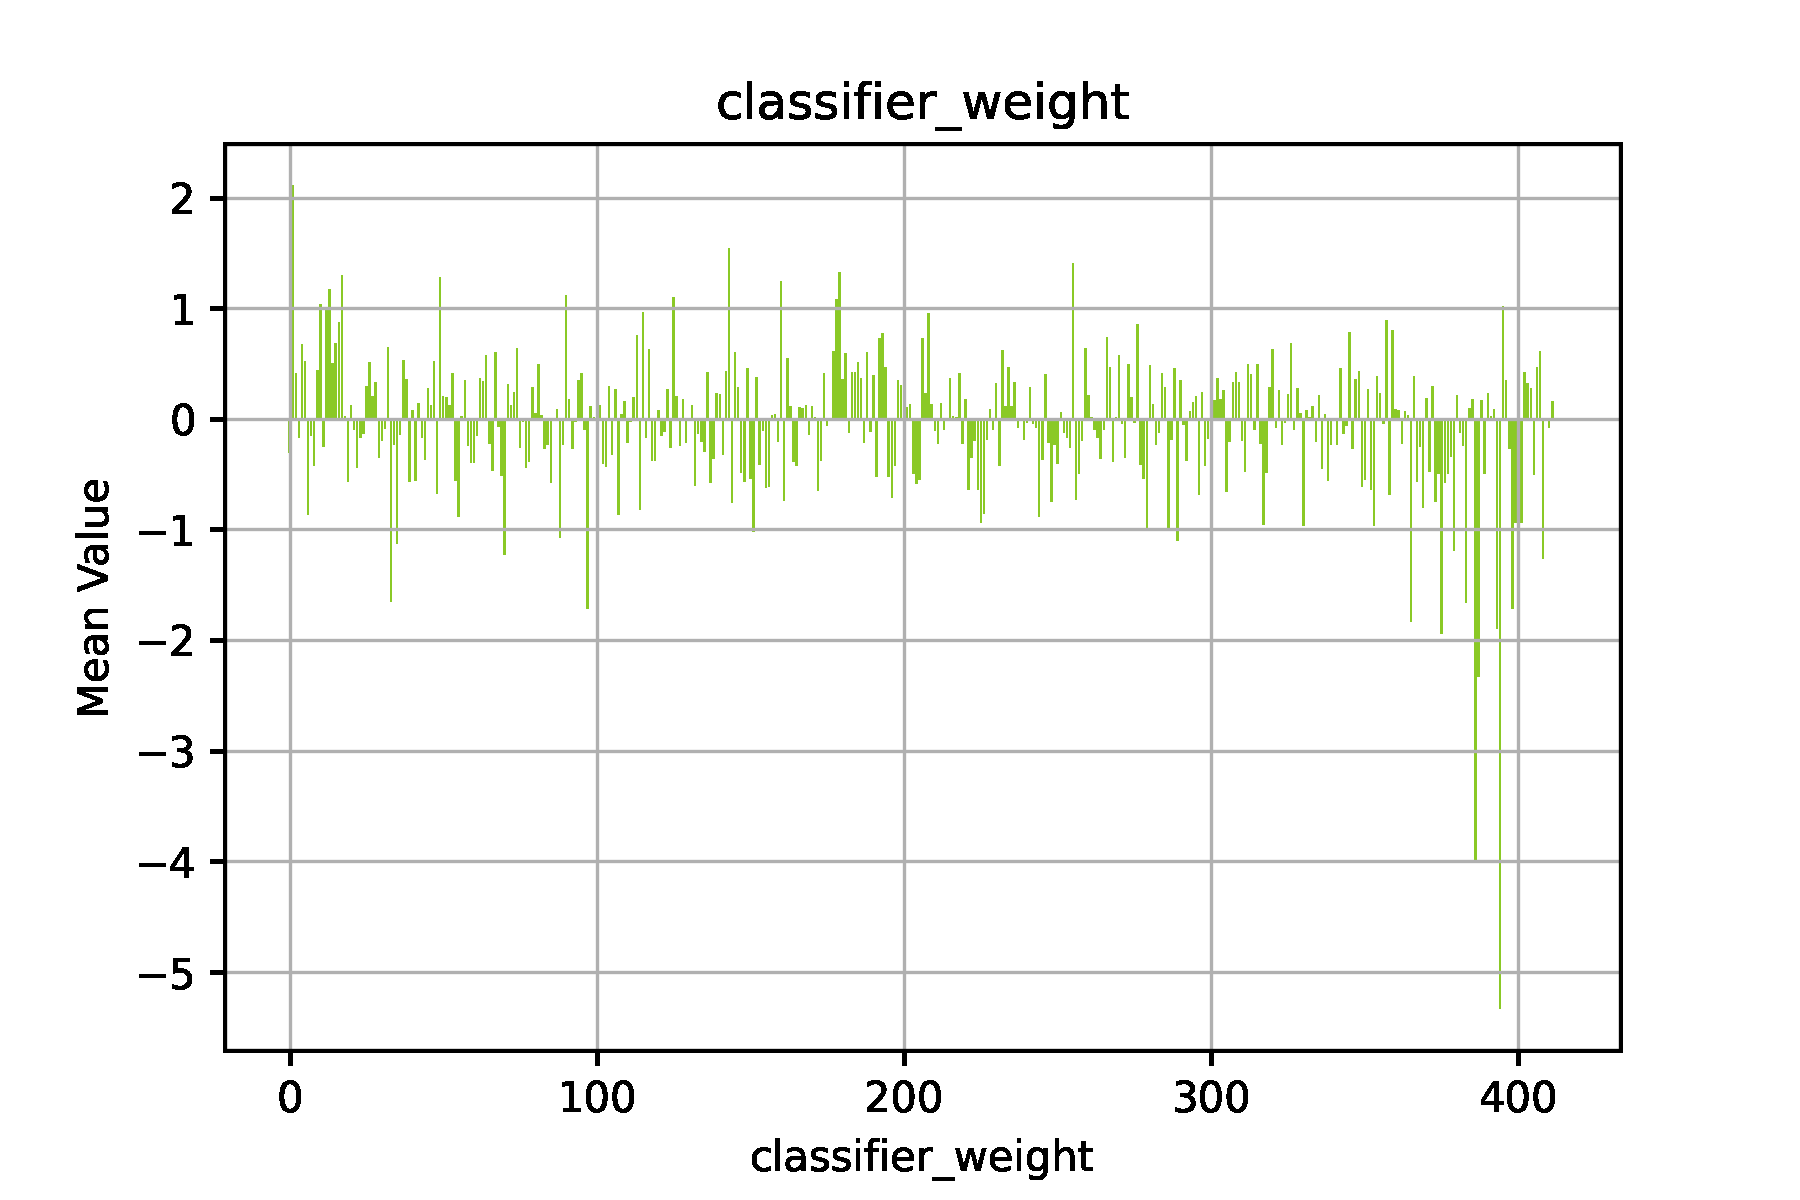

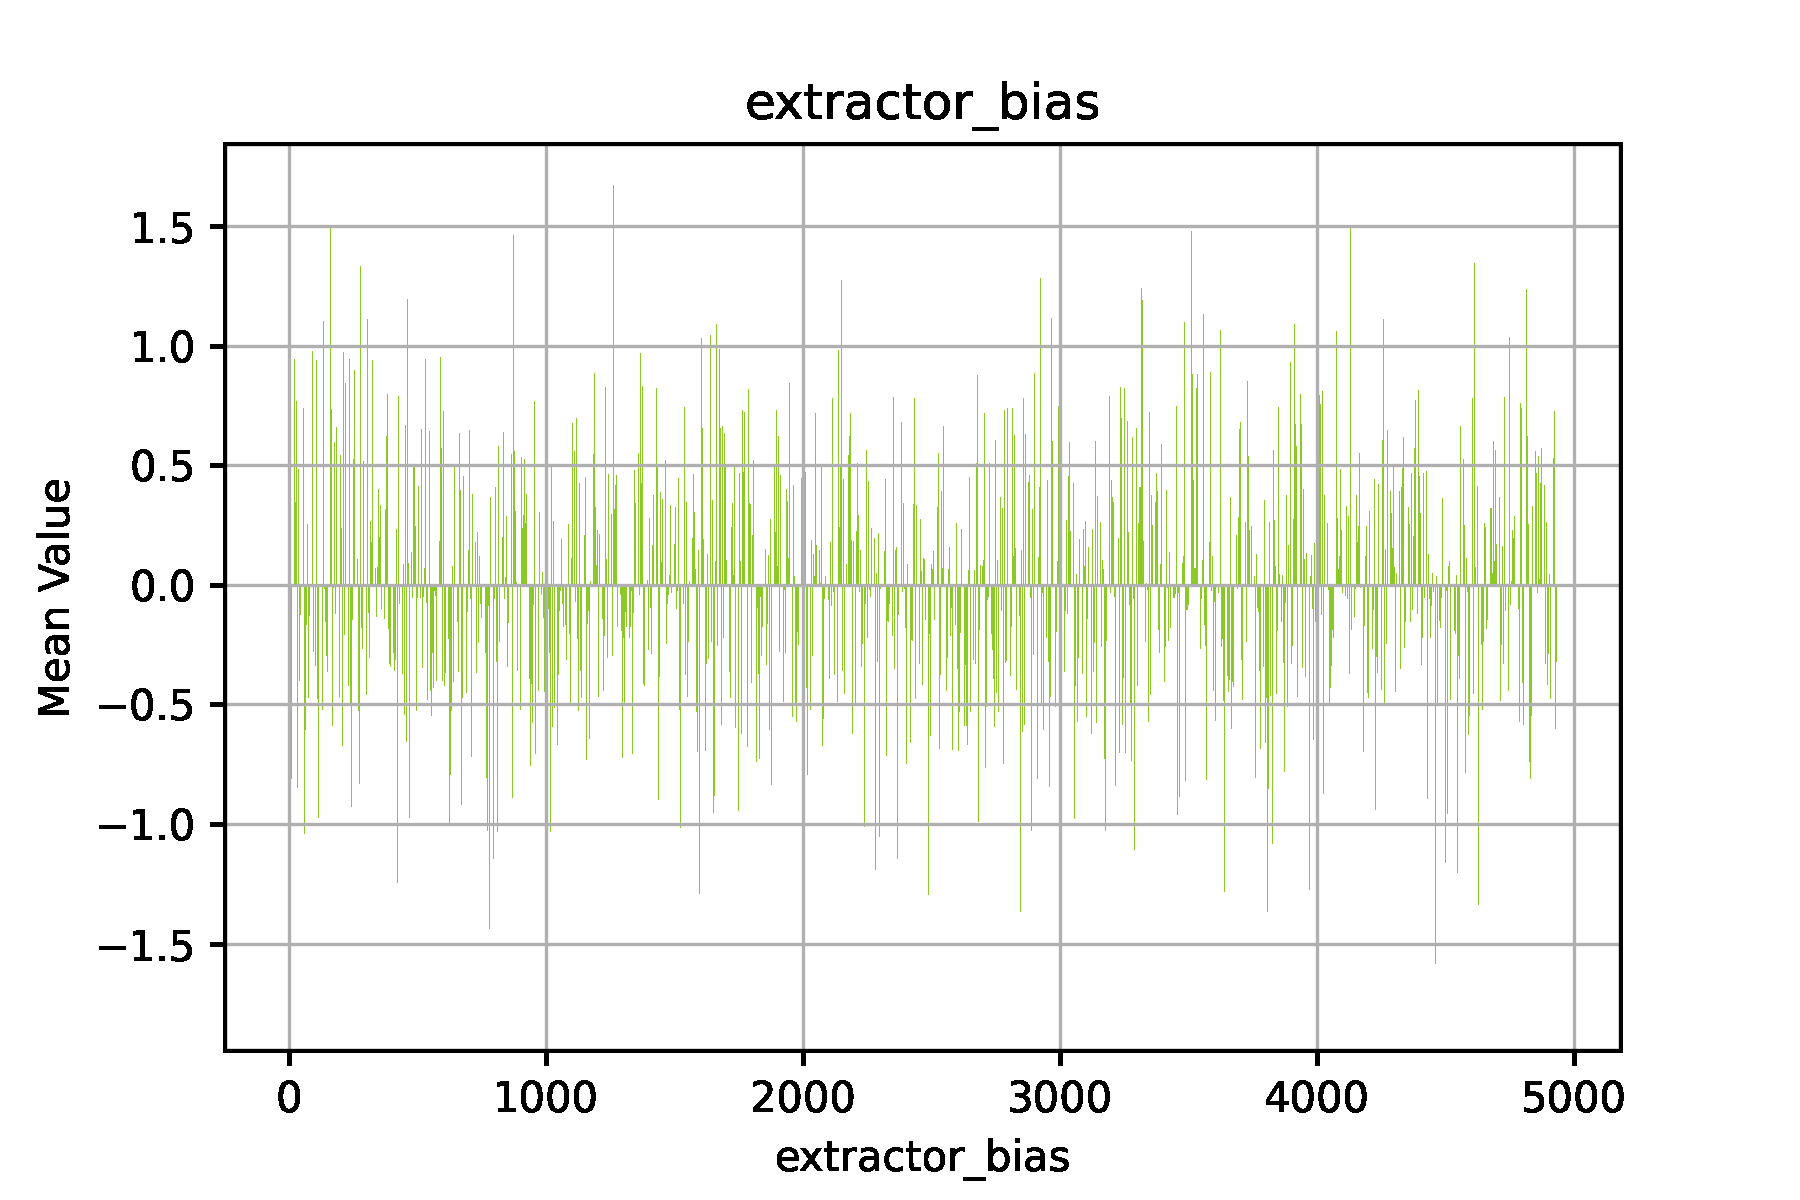

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [21]:
k = "classifier_weight"
visu.plot_bar( mean[k][::100] , x_label= k, y_label='Mean Value', title=k, sort=False, reverse=False, jupyter=True)

k = "extractor_bias"
visu.plot_bar( mean[k][::100] , x_label= k, y_label='Mean Value', title=k, sort=False, reverse=False, jupyter=True)


In [8]:
mean[k][::100].shape

torch.Size([413])

In [10]:
def test_welfords_online_algorithm():
    # For a new value newValue, compute the new count, new mean, the new M2.
    # mean accumulates the mean of the entire dataset
    # M2 aggregates the squared distance from the mean
    # count aggregates the number of samples seen so far
    def update(existingAggregate, newValue):
        (count, mean, M2) = existingAggregate
        count += 1
        delta = newValue - mean
        mean += delta / count
        delta2 = newValue - mean
        M2 += delta * delta2
        return (count, mean, M2)

    # Retrieve the mean, variance and sample variance from an aggregate
    def finalize(existingAggregate):
        (count, mean, M2) = existingAggregate
        if count < 2:
            return float("nan")
        else:
            (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
            return (mean, variance, sampleVariance)

    rva = np.random.randint( 0,100, (1000) )
    rv = rva.tolist()
    a = update( (0, 0, 0), 10 )

    for v in rv[1:]:
        a = update( a, v)
    a = finalize( a )
    print(a)
    print( rva.mean(), rva.std()**2)